In [1]:

import numpy as np
import matplotlib.pyplot as plt

from trend import train_val_test_split, GuerreroTrendEstimator
from trend.plotting import plot_scan, plot_train_val_test_fit


## 1) Get series

In [2]:
from trend.data import from_yahoo
Z, meta = from_yahoo("NVDA", start="2010-01-01", use_log=True)

c:\Users\herie\OneDrive - Fundacion Universidad de las Americas Puebla\Universidad\10 Semestre Primavera\Smoothing-Index-on-Rain-Series-for-Risk-Managment-on-Corn-Futures\trend\data.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [3]:
Z_train, Z_val, Z_test, split = train_val_test_split(Z, frac_train=0.6, frac_val=0.2, min_train=200, min_val=150)

## 2) Scan local minima of validation loss over s

In [4]:

d = 2
est = GuerreroTrendEstimator(d=d, n_train=split.n_train)
scan = est.scan_local_minima(Z_train, Z_val, n_grid=400)

len(scan.minima), scan.minima[:5]


(5,
 [MinimaPoint(s_unit=0.8664273396845185, val_mse=0.27271004022669826),
  MinimaPoint(s_unit=0.9551450002051156, val_mse=0.2469186678004582),
  MinimaPoint(s_unit=0.9776919317260595, val_mse=0.5454796198668902),
  MinimaPoint(s_unit=0.9913840056713463, val_mse=0.8413764742872009),
  MinimaPoint(s_unit=0.9989999925451889, val_mse=0.11312969038445155)])

AttributeError: 'MinimaScan' object has no attribute 's_minima'

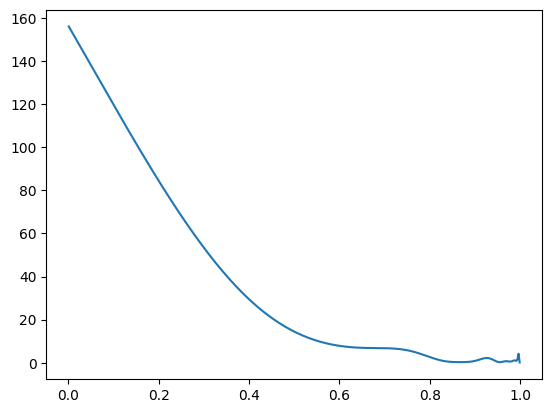

In [5]:

fig, ax = plt.subplots()
plot_scan(scan, title=f"Validation scan | d={d}", ax=ax)
plt.show()


## 3) Fit + for the best minimum

In [6]:

best = scan.best()
best


MinimaPoint(s_unit=0.9989999925451889, val_mse=0.11312969038445155)

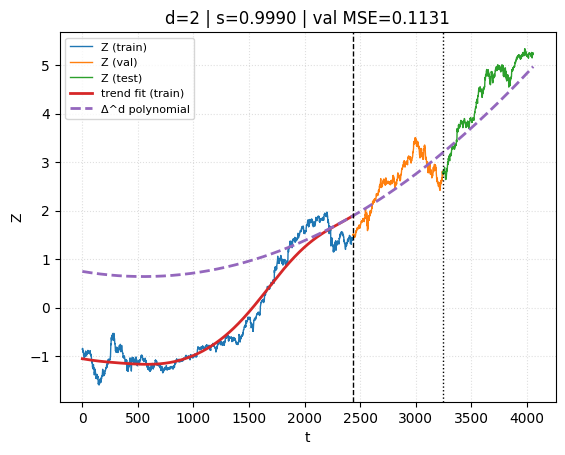

In [7]:

fit = est.fit_train(Z_train, s_unit=best.s_unit)
poly_full = est.build_polynomial_full(
    t_hat_train=fit.t_hat,
    m_hat=fit.m_hat,
    n_total=len(Z),
    n_train=split.n_train,
)

fig, ax = plt.subplots()
plot_train_val_test_fit(
    Z_all=Z,
    n_train=split.n_train,
    n_val=split.n_val,
    t_hat_train=fit.t_hat,
    poly_full=poly_full,
    label="Z",
    title=f"d={d} | s={best.s_unit:.4f} | val MSE={best.val_mse:.4f}",
    ax=ax,
)
plt.show()


## 4) Optional: ARIMA forecast on the fitted trend

This uses `statsmodels` (optional extra). It forecasts the *trend estimate* `t_hat_train`
instead of the Δ^d-polynomial extension.


In [ ]:
fc = est.forecast_trend_arima(fit.t_hat, h=split.n_val, order=(2,0,2))
print("ARIMA order:", fc.order, "AIC:", fc.aic, "BIC:", fc.bic)
print("Forecast shape:", fc.forecast.shape)

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA order: (2, 0, 2) AIC: -27674.21328636755 BIC: -27639.429538726265
Forecast shape: (811,)


c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


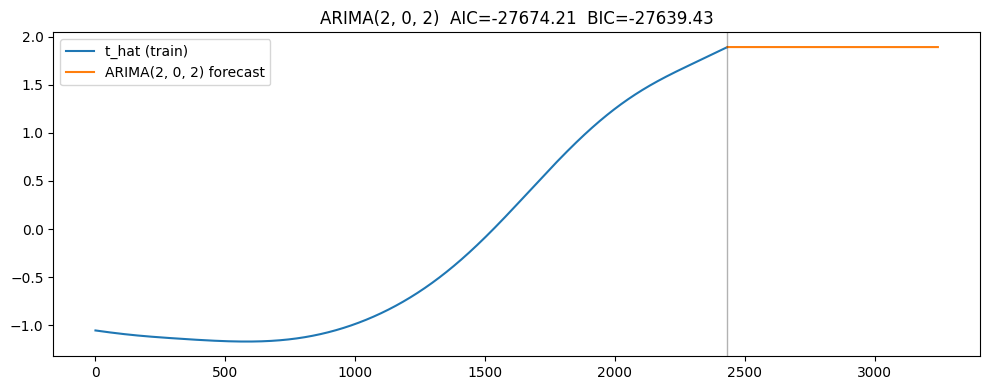

In [9]:
import numpy as np
import matplotlib.pyplot as plt

t_train = np.asarray(fit.t_hat).ravel()
h = split.n_val
fc = est.forecast_trend_arima(t_train, h=h, order=(2,0,2))

x_train = np.arange(len(t_train))
x_fore  = np.arange(len(t_train), len(t_train) + h)

plt.figure(figsize=(10,4))
plt.plot(x_train, t_train, label="t_hat (train)")
plt.plot(x_fore,  fc.forecast, label=f"ARIMA{fc.order} forecast")
plt.axvline(len(t_train)-1, color="k", lw=1, alpha=0.3)
plt.title(f"ARIMA{fc.order}  AIC={fc.aic:.2f}  BIC={fc.bic:.2f}")
plt.legend()
plt.tight_layout()
plt.show()
